In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [6]:
df_products = pd.read_csv('data/processed_prod_data.csv')


/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_31827/2061017201.py:1: DtypeWarning: Columns (15,16,17,18,19,20,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_products = pd.read_csv('data/processed_prod_data.csv')


to-do

- what exactly is a single product in the dataset


- dist of ratings

- dist of product reviews 
- dist of loves 
- dist of product_names per brand_name
- dist of amount, by measurement

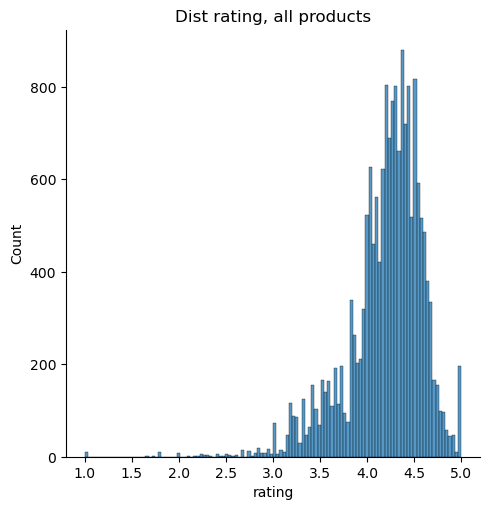

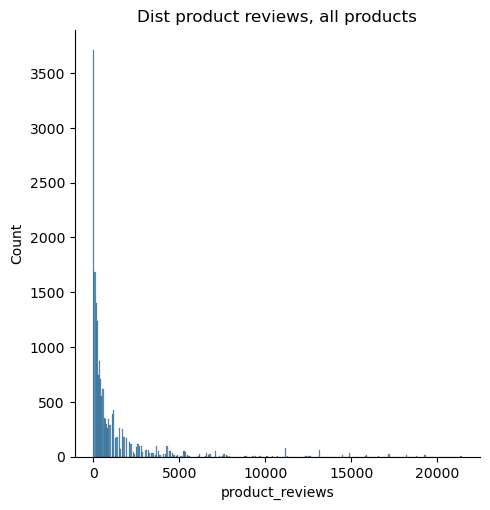

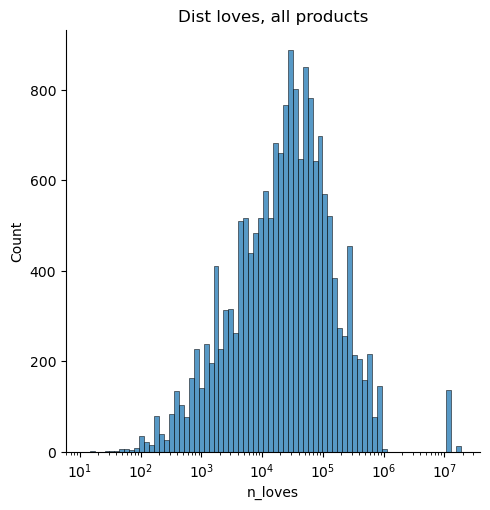

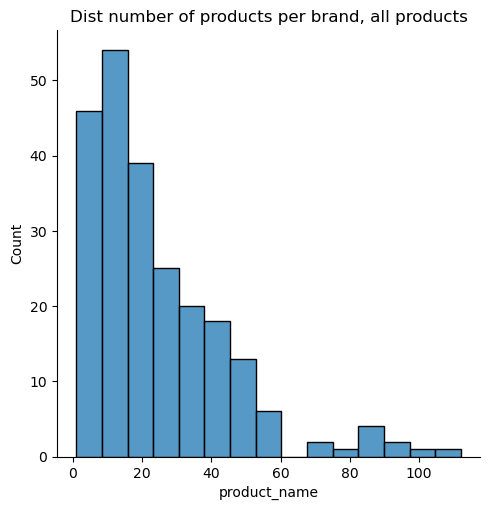

,brand_name,product_name
184,sephora collection,112
122,kérastase,98
24,bumble and bumble,94
133,mac cosmetics,91
210,tom ford,89


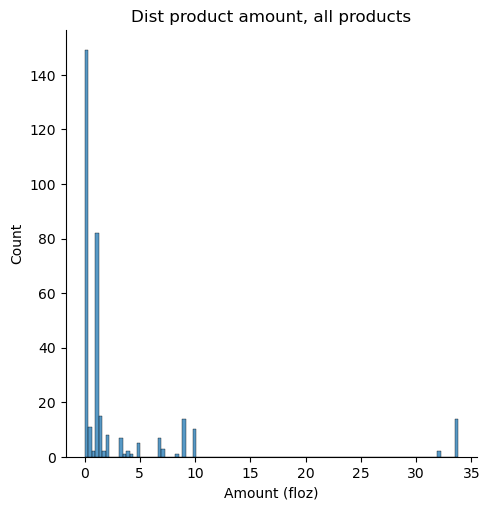

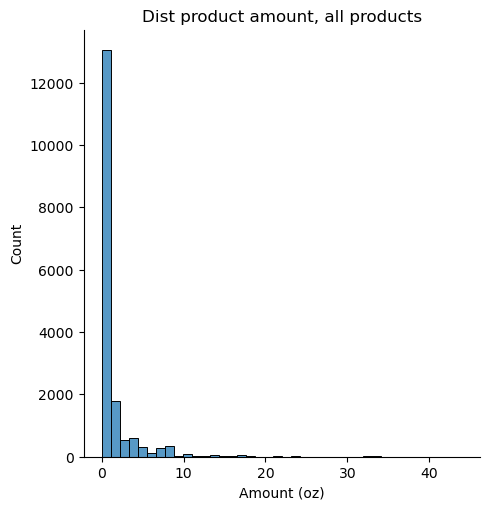

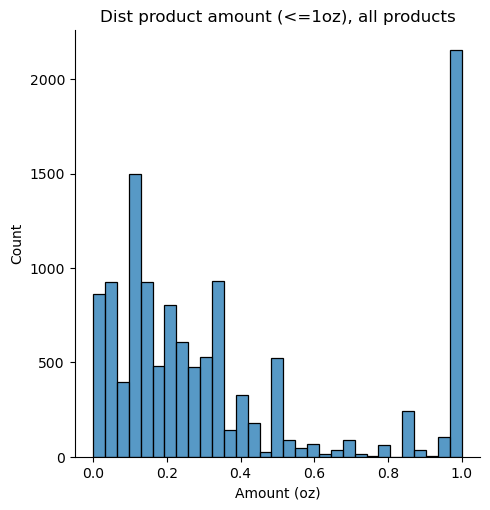

In [33]:

sns.displot(data=df_products, x="rating")
plt.title('Dist rating, all products')
plt.show()

sns.displot(data=df_products, x="product_reviews")#, log_scale=True)
plt.title('Dist product reviews, all products')
plt.show()

sns.displot(data=df_products, x="n_loves", log_scale=True)
plt.title('Dist loves, all products')
plt.show()

prods_per_brand = df_products.groupby('brand_name', as_index=False)['product_name'].nunique()
sns.displot(data=prods_per_brand, x="product_name")
plt.title('Dist number of products per brand, all products')
plt.show()
display(prods_per_brand.sort_values(by='product_name', ascending=False).head())

sns.displot(data=df_products[df_products['unit_a']=='floz'], x="amount_a")
plt.title('Dist product amount, all products')
plt.xlabel('Amount (floz)')
plt.show()

sns.displot(data=df_products[df_products['unit_a']=='oz'], x="amount_a", bins=40)
plt.title('Dist product amount, all products')
plt.xlabel('Amount (oz)')
plt.show()

sns.displot(data=df_products[(df_products['unit_a']=='oz') & (df_products['amount_a']<=1)], x="amount_a")
plt.title('Dist product amount (<=1oz), all products')
plt.xlabel('Amount (oz)')
plt.show()

In [7]:
df_products

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,...,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,swatch_details,unit_price
0,0,https://www.sephora.com/ca/en/product/dr-barba...,face cream rich,dr. barbara sturm,"[{'swatch_group': 'Standard size', 'size': Non...",4.1739,23.0,"-Skullcap: Intensely anti-aging, supports cel...",3400.0,"['Skincare', 'Moisturizers', 'Moisturizers']",...,"{'skuId': ['2269975'], 'icid2': ['products gri...",NaN,NaN,1.69,oz,50.0,ml,NaN,standard size,183.431953
1,1,https://www.sephora.com/ca/en/product/dr-barba...,balancing toner,dr. barbara sturm,"[{'swatch_group': 'Standard size', 'size': Non...",4.5152,33.0,-Sugar Biovector: Regulates the natural pH val...,4800.0,"['Skincare', 'Cleansers', 'Toners']",...,"{'skuId': ['2278729'], 'icid2': ['products gri...",NaN,NaN,5.07,oz,150.0,ml,NaN,standard size,18.737673
2,2,https://www.sephora.com/ca/en/product/dr-barba...,hyaluronic serum,dr. barbara sturm,"[{'swatch_group': 'Standard size', 'size': Non...",3.9352,895.0,-Custom-blended Hyaluronic Acid: A Dr. Sturm ...,7800.0,"['Skincare', 'Treatments', 'Face Serums']",...,"{'skuId': ['2269892'], 'icid2': ['products gri...",NaN,NaN,1.00,oz,30.0,ml,NaN,standard size,410.000000
3,2,https://www.sephora.com/ca/en/product/dr-barba...,hyaluronic serum,dr. barbara sturm,"[{'swatch_group': 'Standard size', 'size': Non...",3.9352,895.0,-Custom-blended Hyaluronic Acid: A Dr. Sturm ...,7800.0,"['Skincare', 'Treatments', 'Face Serums']",...,"{'skuId': ['2269892'], 'icid2': ['products gri...",NaN,NaN,0.33,oz,10.0,ml,NaN,mini size,439.393939
4,3,https://www.sephora.com/ca/en/product/dr-barba...,super anti-aging face cream,dr. barbara sturm,"[{'swatch_group': 'Standard size', 'size': Non...",4.6000,235.0,"-Plankton Biopolymers: Support firm, supple sk...",1200.0,"['Skincare', 'Moisturizers', 'Moisturizers']",...,"{'skuId': ['2425197'], 'icid2': ['products gri...",NaN,NaN,1.70,oz,50.0,ml,NaN,standard size,275.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17772,7923,https://www.sephora.com/ca/en/product/guerlain...,abeille royale anti-aging fortifying lotion toner,guerlain,"[{'swatch_group': 'Standard size', 'size': Non...",4.2566,834.0,Guerlain Exclusive Royal Jelly: Inspired by be...,6800.0,"['Skincare', 'Cleansers', 'Toners']",...,"{'skuId': ['2384436'], 'icid2': ['products gri...",NaN,NaN,10.00,oz,300.0,ml,NaN,value size,16.300000
17773,7925,https://www.sephora.com/ca/en/product/guerlain...,aqua allegoria forte rosa rossa eau de parfum,guerlain,"[{'swatch_group': 'Standard size', 'size': Non...",5.0000,1.0,"Alcohol, Parfum (Fragrance), Aqua (Water), Lin...",492.0,"['Fragrance', 'Women', 'Perfume']",...,"{'skuId': ['2657369'], 'icid2': ['products gri...",NaN,NaN,2.50,oz,75.0,ml,eau de parfum spray,standard size,62.400000
17774,7926,https://www.sephora.com/ca/en/product/guerlain...,abeille royale advanced youth watery oil,guerlain,"[{'swatch_group': 'Standard size', 'size': Non...",4.3442,1300.0,-Dynamic Black Bee Repair Technology: Four sus...,15100.0,"['Skincare', 'Moisturizers', 'Face Oils']",...,"{'skuId': ['2492858'], 'icid2': ['products gri...",NaN,NaN,1.00,oz,30.0,ml,NaN,standard size,139.000000
17775,7926,https://www.sephora.com/ca/en/product/guerlain...,abeille royale advanced youth watery oil,guerlain,"[{'swatch_group': 'Standard size', 'size': Non...",4.3442,1300.0,-Dynamic Black Bee Repair Technology: Four sus...,15100.0,"['Skincare', 'Moisturizers', 'Face Oils']",...,"{'skuId': ['2492858'], 'icid2': ['products gri...",NaN,NaN,0.50,oz,15.0,ml,NaN,standard size,148.000000


In [ ]:
olid_products = df_products[(df_products['unit_a']=='oz')]

solid_products = solid_products.groupby(['brand_name','product_name','swatch_group'], as_index=False).agg({
    'sku':['unique','count'],
    'rating':'first',
    'product_reviews':'first',
    'price':['first','unique','nunique'],
    'size':'first',
    'name':'nunique',
    'amount_a':'first',
    'unit_a':'first',
    'amount_b':'first',
    'unit_b':'first',
    'lvl_0_cat':'first',
    'lvl_1_cat':'first',
    'lvl_2_cat':'first'
})
solid_products.columns = ['_'.join(x) for x in solid_products.columns]


In [ ]:
df_products.groupby(['unit_a','unit_b'])['internal_product_id'].count().head(100)

In [ ]:
# def conv_solid(row):

#     return ureg(str(row['amount_a'])+" "+row['unit_a']).to(row['unit_b'])

# solid_products['a_conv'] = solid_products.apply(conv_solid, axis=1)
# solid_products['a_conv_magnitude'] = solid_products['a_conv'].apply(lambda x : x.magnitude)

In [ ]:

solid_products.lvl_2_cat_first.value_counts()

In [ ]:

# df_products_tree = df_products.groupby(['lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], as_index=False)['internal_product_id'].count()
# fig = px.treemap(df_products_tree, path=[px.Constant("all"), 'lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], values='internal_product_id')
# fig.update_traces(root_color="lightgrey")
# fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
# fig.show()

In [ ]:
fig = px.scatter(solid_products[solid_products['lvl_2_cat_first']=='Eyebrow'], x="amount_a_first", y="price_first", color="swatch_group_", hover_data=['brand_name_', 'product_name_'])
fig.show()

In [ ]:
solid_products['unit_price'] = solid_products['amount_a_first']/solid_products['price_first']#.hist()

In [ ]:
solid_products['unit_price'].hist()
plt.yscale('log')

In [ ]:
# solid_products.sort_values(by='unit_price',ascending=False)

In [ ]:
# df_products
# EDA - what is the distribution of product reviews
# scatter reviews v ratings

sns.scatterplot(data=df_products, x="product_reviews", y="rating", alpha=0.5)
plt.show()
# how many products have no reviews?
# interesting outliers - looked at reviews, truly bad
display(df_products[(df_products['product_reviews']>4000) & (df_products['rating']<3.2)])


# scattr review v loves
# the handful of outliers are so interesting
# was there a promotion to add these to loves list?
sns.scatterplot(data=df_products, x="product_reviews", y="n_loves", alpha=0.5)
plt.show()
display(df_products[(df_products['n_loves']>1500000)]['product_name'].unique())
sns.scatterplot(data=df_products, x="product_reviews", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()
# scatter n loves v price 
sns.scatterplot(data=df_products, x="price", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()


sns.scatterplot(data=df_products, x="price", y="rating", alpha=0.5)
plt.show()

sns.scatterplot(data=df_products, x="price", y="product_reviews", alpha=0.5)
plt.show()

sns.scatterplot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", y="rating", alpha=0.5)
plt.xscale('log')
plt.show()

sns.scatterplot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", y="n_loves", alpha=0.5)
plt.show()

In [ ]:
df_products.sort_values(by='unit_price', ascending=False)

## Swatch group comparisons

In [ ]:
df = df_products[df_products['lvl_2_cat']=='Mascara'].groupby(['brand_name','product_name','swatch_group','unit_a'], as_index=False).agg({
    'internal_product_id':'count',
    'unit_price':'mean',
    'price':'mean',
    'amount_a':'mean'
})


In [ ]:
df = df[df.groupby(['brand_name','product_name','unit_a'])['swatch_group'].transform(lambda x : x.nunique()>1)]

df['full_product'] = df['brand_name']+' '+ df['product_name']
df = df.pivot(index='full_product', columns='swatch_group', values='unit_price') # ['unit_a',]
df = df.reset_index()

In [ ]:
df = df[['full_product','mini size','standard size']]

In [ ]:
df = df.set_index('full_product').stack('swatch_group').reset_index().rename(columns={0:'unit_price'})

In [ ]:

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df, x="swatch_group", y="unit_price", hue="full_product",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [ ]:
# in bare minerals - mini size == standard

In [ ]:
issue_brands = ['Tom Ford', 'tarte', 'Moroccanoil', 'Dior', 'Anastasia Beverly Hills']
prods = ['clinique']
# url = 'https://www.sephora.com/ca/en/product/charlotte-tilbury-airbrush-flawless-setting-spray-P461147?skuId=2368439&icid2=products%20grid:p461147:product'

# url = 'https://www.sephora.com/ca/en/product/ambient-lighting-blush-collection-P384963?skuId=1581321&icid2=products%20grid:p384963:product'
# lots of options all same size
# url = "https://www.sephora.com/ca/en/product/saie-glowy-super-skin-lightweight-hydrobounce-serum-foundation-P504907?icid2=new_ca_skugrid_ufe:p504907:product"
# ran into issue getting product name
# url = "https://www.sephora.com/ca/en/product/book-personal-travel-spray-P501954?icid2=homepage_productlist_brandnewadditions_ca_rwd_092022"
# value set works
# url = 'https://www.sephora.com/ca/en/product/laneige-midnight-to-morning-hydration-set-P504208?skuId=2639557&icid2=products%20grid:p504208:product'
# hair brush with no ingredients
# url = 'https://www.sephora.com/ca/en/product/sephora-collection-scalp-massager-P472069?skuId=2414555&icid2=products%20grid:p472069:product'
# new prod
# url = 'https://www.sephora.com/ca/en/product/gxve-by-gwen-stefani-check-my-glow-platinum-glow-highlighter-P505655?icid2=new_ca_skugrid_ufe:p505655:product'
# sale prod
# url = 'https://www.sephora.com/ca/en/product/green-microalgae-retinol-regenerating-serum-P506077?skuId=2672301&icid2=products%20grid:p506077:product'
# no reviews yet or ratings

# broken page https://www.sephora.com/ca/en/product/beautyblender-bronze-besties-P505630?skuId=2662559&icid2=products


with open(data_dir+'brand_data.json') as file:
    brand_data = json.loads(file.read())